In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from vaemols.models import VariationalAutoencoder
from vaemols.utils import smiles_to_labels, labels_to_smiles, filter_smiles_to_mols

from rdkit import Chem
from rdkit.Chem import Draw

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import logging

logging.basicConfig(level=logging.INFO)

char_data = np.load('data/char_data.npz')
int_to_char = char_data['int_to_char'].item()
char_to_int = char_data['char_to_int'].item()
num_classes = len(char_to_int)

max_length = 120

data = pd.read_csv('data/structures.csv', index_col=0)
smiles_data = list(data['structure'])
labeled_data_to_compare = smiles_to_labels(smiles_data, char_to_int, max_length)

input_data_labeled = np.load('data/x_train.npy')

restore_model_dir = 'saved_models/'
restore_model_path = tf.train.latest_checkpoint(restore_model_dir)
logging.info(restore_model_path)

INFO:root:saved_models/weights-17-274.7396.ckpt


In [2]:
latent_dim = 256
inputs = tf.keras.layers.Input(shape=(max_length, num_classes))
vae = VariationalAutoencoder(latent_dim, num_classes, max_length, num_samples=1)
outputs = vae(inputs)

sess = tf.Session()
with sess.as_default():
    vae.load_weights(restore_model_path)

In [3]:
batch_size = 64
num_batch = len(input_data_labeled)//batch_size + 1

z_mean = np.concatenate([sess.run(vae.z_mean, 
                                  feed_dict={vae.input:tf.keras.utils.to_categorical(
                                      input_data_labeled[i*batch_size:(i+1)*batch_size], num_classes=num_classes)})
                         for i in range(num_batch)], axis=0)

In [4]:
z_data = sess.run(vae.z_mean, feed_dict={vae.input:tf.keras.utils.to_categorical(
                                labeled_data_to_compare[:1], num_classes=num_classes)})

In [5]:
z_latent = tf.placeholder(tf.float32, shape=vae.z_mean.shape)
z_data_to_compare = tf.placeholder(tf.float32, shape=vae.z_mean.shape)

def pair_wise_dist(a, b):
    norm_a = tf.reduce_sum(tf.square(a), 1)
    norm_b = tf.reduce_sum(tf.square(b), 1)
    col_vec_a = tf.reshape(norm_a, [-1, 1])
    col_vec_b = tf.reshape(norm_b, [1, -1])
    dist = tf.sqrt(tf.maximum(col_vec_a - 2*tf.matmul(a, b, transpose_a=False, transpose_b=True) + col_vec_b, 0.0))
    return dist

z_dist = pair_wise_dist(z_data_to_compare, z_latent)
top_k_val, top_k_idx = tf.nn.top_k(-z_dist, k=20)

In [6]:
val, idx = sess.run([top_k_val, top_k_idx], feed_dict={z_latent:z_mean, z_data_to_compare:z_data})

In [7]:
top_k_data = input_data_labeled[np.squeeze(idx)]
top_k_smiles = labels_to_smiles(np.squeeze(top_k_data), int_to_char)
valid_mols = filter_smiles_to_mols(top_k_smiles)

INFO:root:Number of input smiles: 20
INFO:root:Number of unique input smiles: 20
INFO:root:Number of unique valid mols: 20


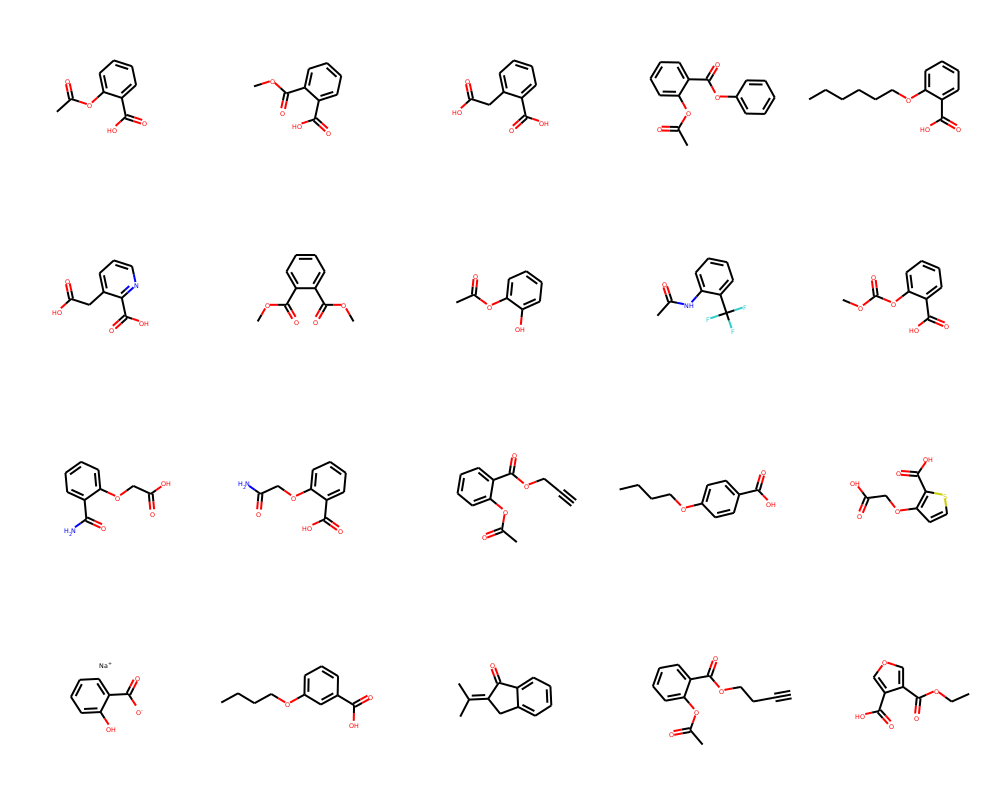

In [8]:
Draw.MolsToGridImage([mol for mol in valid_mols], molsPerRow=5)